In [1]:
import torch
import matplotlib.pyplot as plt
from torch_sampling import choice

# Checking non-contiguous tensors

In [2]:
x = torch.arange(10)
y = x[::3]
for t in [x, y]:
    print(t.is_contiguous())

True
False


In [3]:
k=3
print("Sampling with replacement:")
for _ in range(5):
    print(choice(y, k, True))
print("Sampling without replacement:")
for _ in range(5):
    print(choice(y, k, False))

Sampling with replacement:
tensor([3, 0, 3])
tensor([0, 3, 6])
tensor([9, 9, 3])
tensor([9, 3, 0])
tensor([3, 0, 6])
Sampling without replacement:
tensor([0, 3, 6])
tensor([0, 3, 6])
tensor([0, 3, 9])
tensor([0, 3, 9])
tensor([0, 3, 6])


In [4]:
x = torch.arange(10).cuda()
y = x[::3]
for t in [x, y]:
    print(t.is_contiguous())

True
False


In [7]:
k=3
print("Sampling with replacement:")
for _ in range(5):
    print(choice(y, k, True))
print("Sampling without replacement:")
for _ in range(5):
    print(choice(y, k, False))

Sampling with replacement:
tensor([9, 6, 9], device='cuda:0')
tensor([3, 0, 9], device='cuda:0')
tensor([9, 6, 0], device='cuda:0')
tensor([0, 9, 6], device='cuda:0')
tensor([6, 9, 0], device='cuda:0')
Sampling without replacement:
tensor([0, 3, 9], device='cuda:0')
tensor([9, 3, 6], device='cuda:0')
tensor([0, 3, 9], device='cuda:0')
tensor([9, 3, 6], device='cuda:0')
tensor([0, 3, 9], device='cuda:0')


# Checking determinism

In [9]:
x = torch.arange(10)
torch.manual_seed(1234)
print(choice(x, k, True))
torch.manual_seed(1234)
print(choice(x, k, True))

tensor([5, 1, 6])
tensor([5, 1, 6])


In [10]:
x = torch.arange(10).cuda()
torch.manual_seed(1234)
print(choice(x, k, True))
torch.manual_seed(1234)
print(choice(x, k, True))

tensor([5, 1, 9], device='cuda:0')
tensor([5, 1, 9], device='cuda:0')


# Check performance for multi-d tensors

In [11]:
x = torch.arange(10**4).view(-1, 2)
n = x.size(0)
k = 3
idx = torch.arange(n)

In [12]:
%timeit x[torch.randperm(n)[:k]]

67.3 µs ± 1.43 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
%timeit x[choice(idx, k, True)]

11.3 µs ± 14 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
%timeit x[choice(idx, k, False)]

18 µs ± 203 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Checking the performance

In [15]:
x = torch.arange(10**4)

# Case 1: k big

In [16]:
k = 9000

In [17]:
%timeit choice(x, k, True)

96 µs ± 77.1 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit choice(x, k, False)

46.1 µs ± 47.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
%timeit x[torch.randperm(x.numel())[:k]]

165 µs ± 72.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Case 2: k small

In [20]:
k = 100

In [21]:
%timeit choice(x, k, True)

5.41 µs ± 8.68 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [22]:
%timeit choice(x, k, False)

13.9 µs ± 296 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [23]:
%timeit x[torch.randperm(x.numel())[:k]]

123 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Case 3: k medium

In [24]:
k = 4500

In [25]:
%timeit choice(x, k, True)

50.2 µs ± 45.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [26]:
%timeit choice(x, k, False)

68.1 µs ± 32.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [27]:
%timeit x[torch.randperm(x.numel())[:k]]

144 µs ± 756 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# CUDA vs CPU

In [45]:
x_cpu = torch.arange(10**7)
x_cuda = x_cpu.cuda()
k = 10**4

In [46]:
%timeit choice(x_cpu, k, True)

195 µs ± 65.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
%timeit choice(x_cuda, k, True);torch.cuda.synchronize()

26.1 µs ± 67.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [48]:
%timeit choice(x_cpu, k, False)

7.99 ms ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%timeit choice(x_cuda, k, False);torch.cuda.synchronize()

3.35 ms ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
weights_cpu = torch.ones(10**7).double()
weights_cuda = weights_cpu.cuda()

In [51]:
%timeit choice(x_cpu, k, False, weights_cpu)

331 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%timeit choice(x_cuda, k, False, weights_cuda);torch.cuda.synchronize()

85.3 ms ± 933 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Checking distributions - Uniform

In [53]:
x = torch.arange(10)

### CPP Extension

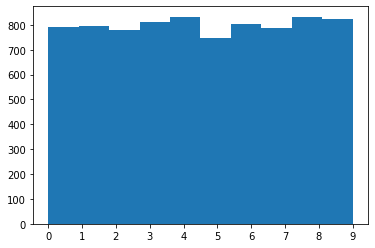

In [54]:
k = 8
samples = []
for _ in range(1000):
    samples.extend(choice(x, k, True).numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

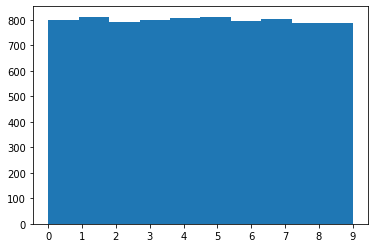

In [55]:
k = 8
samples = []
for _ in range(1000):
    samples.extend(choice(x, k, False).numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

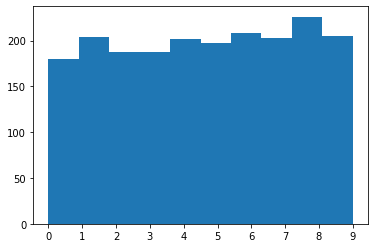

In [56]:
k = 2
samples = []
for _ in range(1000):
    samples.extend(choice(x, k, True).numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

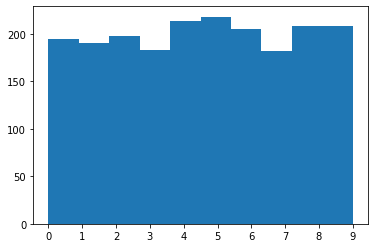

In [57]:
k = 2
samples = []
for _ in range(1000):
    samples.extend(choice(x, k, False).numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

### CUDA Extension

In [58]:
x = x.cuda()

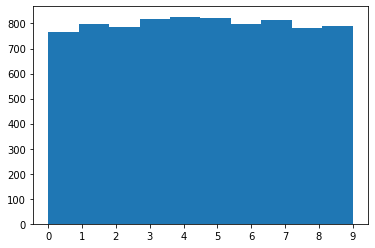

In [63]:
k = 8
samples = []
for _ in range(1000):
    samples.extend(choice(x, k,True).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

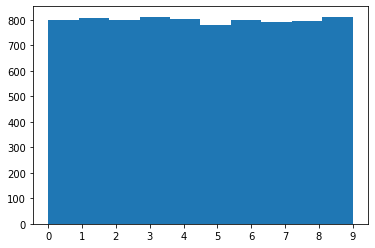

In [64]:
k = 8
samples = []
for _ in range(1000):
    samples.extend(choice(x, k, False).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

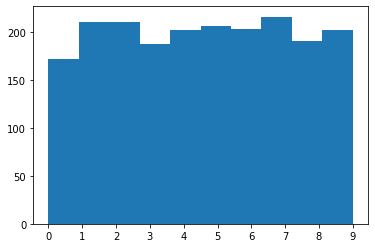

In [65]:
k = 2
samples = []
for _ in range(1000):
    samples.extend(choice(x, k, True).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

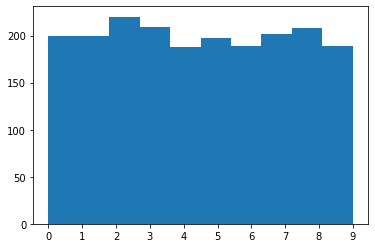

In [66]:
k = 2
samples = []
for _ in range(1000):
    samples.extend(choice(x, k, False).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

# Checking distributions - Weighted

In [68]:
x = torch.arange(10)
weights = torch.Tensor([1, 1, 5, 5, 5, 1, 7, 2, 2, 2]).float()

### CPP Extension

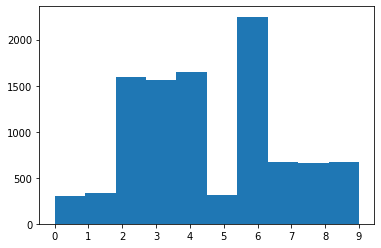

In [69]:
k = 1
samples = []
for _ in range(10000):
    samples.extend(choice(x, k, True, weights).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

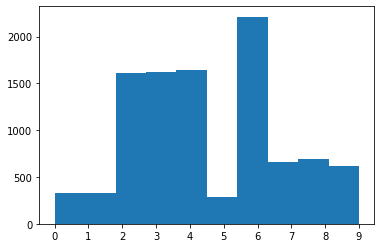

In [70]:
k = 1
samples = []
for _ in range(10000):
    samples.extend(choice(x, k, False, weights).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

### CUDA Extension

In [71]:
x = x.cuda()
weights = weights.cuda()

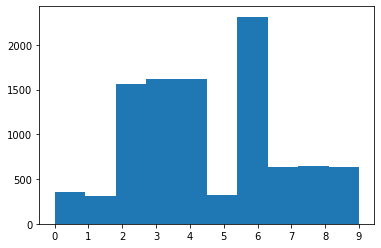

In [72]:
k = 1
samples = []
for _ in range(10000):
    samples.extend(choice(x, k, True, weights).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

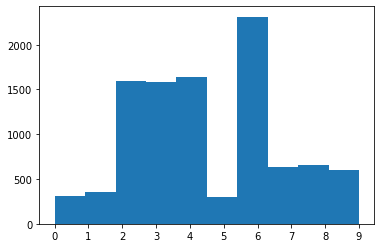

In [73]:
k = 1
samples = []
for _ in range(10000):
    samples.extend(choice(x, k, False, weights).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()